The human heart, on average, will beat approximately 100,000 times each day and circulate roughly 2,000 gallons of blood through an extensive network of vessels stretching over 60,000 miles within the body.

Heart attack symptoms can manifest differently between genders, often being subtler in women. A female heart attack sufferer might experience a range of symptoms including a peculiar chest discomfort or pain, which could also spread to the arms, back, neck, jaw, or stomach, accompanied by difficulty breathing, nausea, and other varied signs. Men typically present more recognizable heart attack indicators such as pronounced chest pain or discomfort and stress, and similar to women, they might also suffer pain in several parts of the upper body along with symptoms like sweating and a sensation akin to indigestion.

For an organ that's merely the size of a large fist and tips the scales at just 8 to 12 ounces, the heart's workload is indeed formidable.

Orignal Data Source : [https://archive.ics.uci.edu/ml/datasets/Heart+Disease]

** The dataset was created by: **
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

**The dataset contains the following features:**

- **age**: The individual's age in years.
- **sex**: The individual's sex (1 = male, 0 = female).
- **cp**: Type of chest pain experienced.
  - 0: Asymptomatic
  - 1: Atypical angina
  - 2: Non-anginal pain
  - 3: Typical angina
- **trestbps**: The individual's resting blood pressure (in mm Hg on admission to the hospital).
- **chol**: The individual's cholesterol measurement in mg/dl.
- **fbs**: The individual's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false).
- **restecg**: Resting electrocardiographic results.
  - 0: Probable or definite left ventricular hypertrophy by Estes' criteria.
  - 1: Normal.
  - 2: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV).
- **thalach**: The individual's maximum heart rate achieved.
- **exang**: Exercise-induced angina (1 = yes; 0 = no).
- **oldpeak**: ST depression induced by exercise relative to rest.
- **slope**: The slope of the peak exercise ST segment.
  - 0: Downsloping.
  - 1: Flat.
  - 2: Upsloping.
- **ca**: The number of major vessels (0-3) colored by fluoroscopy.
- **thal**: The status of thalassemia, a blood disorder.
  - 0: NULL (dropped from the dataset).
  - 1: Fixed defect (no blood flow in some part of the heart).
  - 2: Normal blood flow.
  - 3: Reversible defect (blood flow is observed but it is not normal).
- **target**: Presence of heart disease (1 = no, 0 = yes).



In [2]:
#Installing the required packages
#!pip install pgmpy

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination# Load the dataset
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
import pandas as pd

# Loading the Dataset
url = 'https://raw.githubusercontent.com/crbeveridge1065/ml_data/main/heart.csv'
df = pd.read_csv(url)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


I need to bin the continuous variables to make the network easier to work with....

In [3]:
# Age binning
age_bins = [0, 30, 60, 120]
age_labels = ['Young', 'Middle-aged', 'Elderly']
df['age_binned'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Resting blood pressure binning
trestbps_bins = [0, 120, 140, 200]  # Assuming standard classification
trestbps_labels = ['Low', 'Normal', 'High']
df['trestbps_binned'] = pd.cut(df['trestbps'], bins=trestbps_bins, labels=trestbps_labels, include_lowest=True)

# Cholesterol binning
chol_bins = [0, 200, 239, 600]  # Assuming standard classification
chol_labels = ['Desirable', 'Borderline high', 'High']
df['chol_binned'] = pd.cut(df['chol'], bins=chol_bins, labels=chol_labels, include_lowest=True)

# Maximum heart rate achieved binning
# For 'thalach', we use quantiles as the values might be relative to age/fitness
thalach_bins = pd.qcut(df['thalach'], q=3, labels=['Below Average', 'Average', 'Above Average'])
df['thalach_binned'] = thalach_bins

# ST depression binning
oldpeak_bins = [0, 1, 2, 6]  # Custom bins based on clinical relevance
oldpeak_labels = ['Minimal', 'Moderate', 'Severe']
df['oldpeak_binned'] = pd.cut(df['oldpeak'], bins=oldpeak_bins, labels=oldpeak_labels, include_lowest=True)

# Drop the original continuous variables
df = df.drop(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'], axis=1)




/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

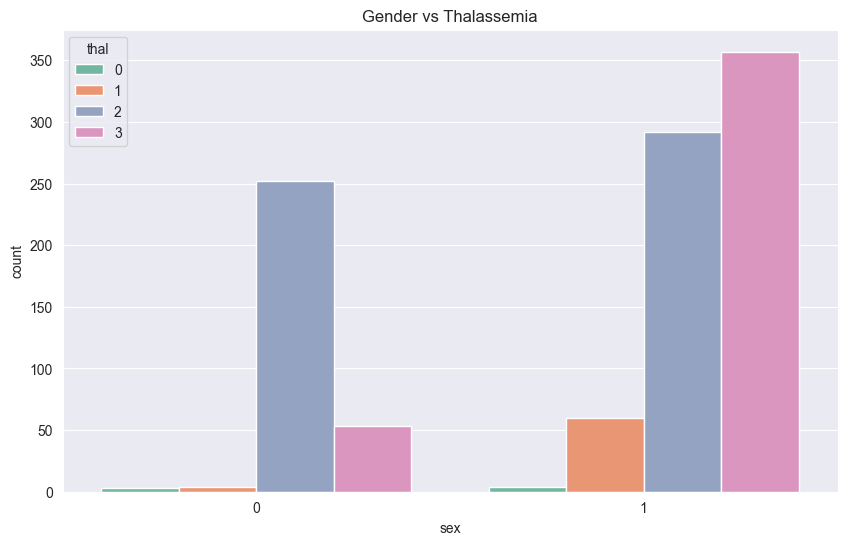

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.set_palette('Set2')

# Gender vs Thalassemia
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sex', hue='thal')
plt.title('Gender vs Thalassemia')
plt.show()

/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

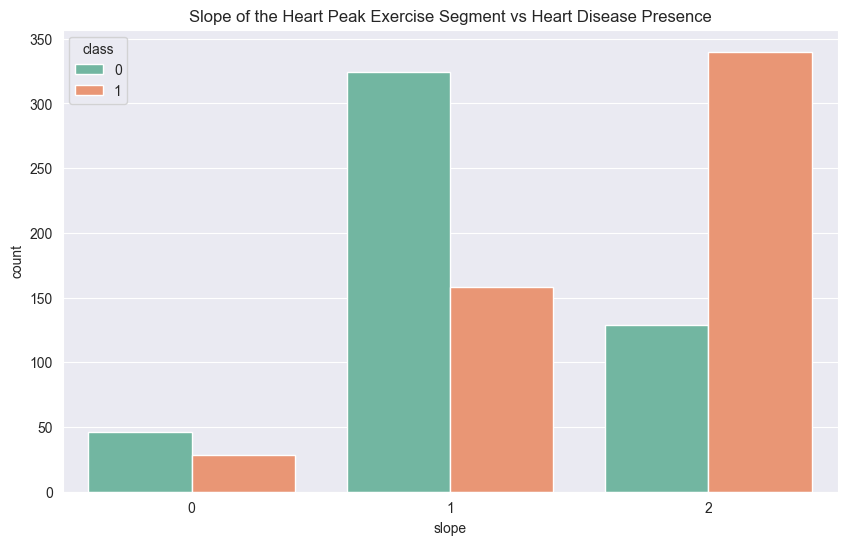

In [42]:
# Slope vs Target (Heart Disease Presence)
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='slope', hue='class')
plt.title('Slope of the Heart Peak Exercise Segment vs Heart Disease Presence')
plt.show()


/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

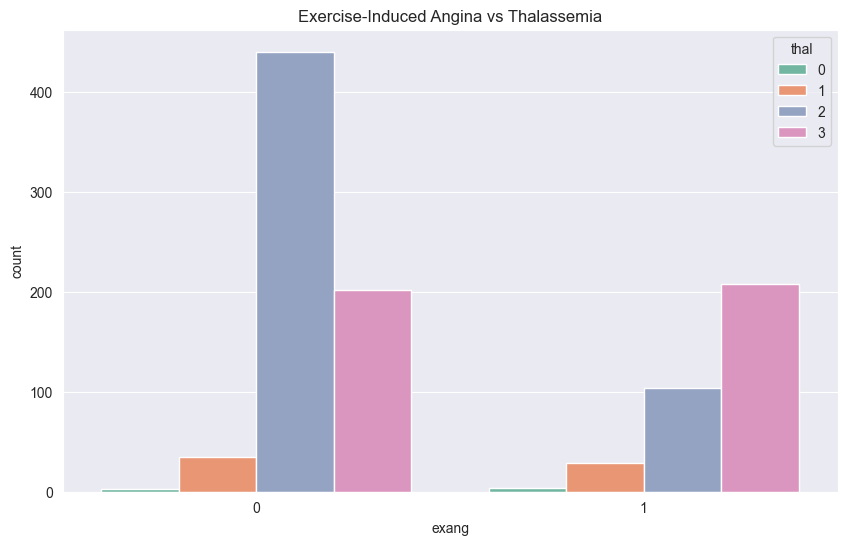

In [43]:
# Exercise-Induced Angina vs Thalassemia
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='exang', hue='thal')
plt.title('Exercise-Induced Angina vs Thalassemia')
plt.show()


/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.

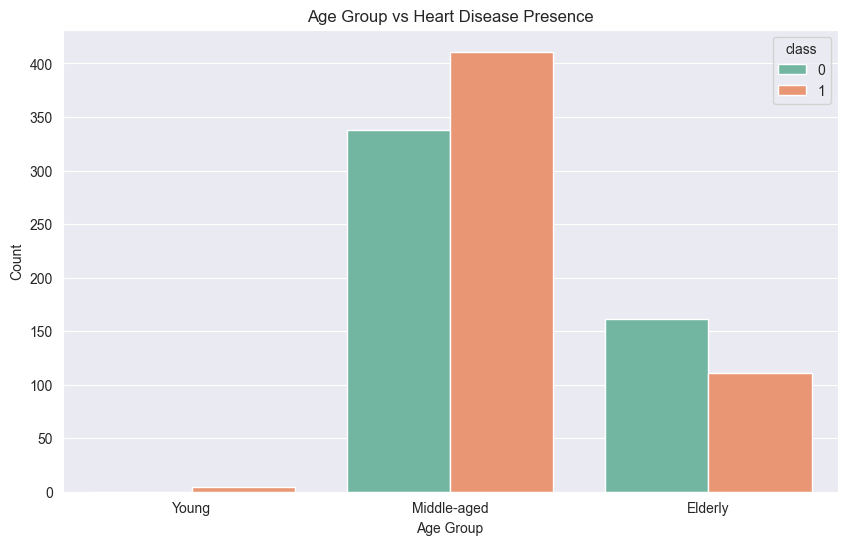

In [44]:
# Countplot for Age Bins by Heart Disease Presence
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_binned', hue='class')
plt.title('Age Group vs Heart Disease Presence')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()


/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


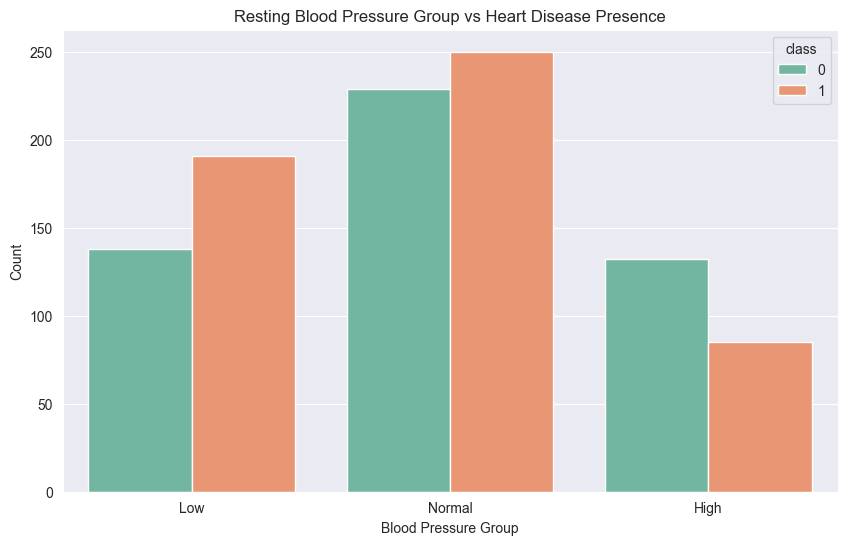

In [45]:
# Countplot for Resting Blood Pressure Bins by Heart Disease Presence
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='trestbps_binned', hue='class')
plt.title('Resting Blood Pressure Group vs Heart Disease Presence')
plt.xlabel('Blood Pressure Group')
plt.ylabel('Count')
plt.show()


/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/seaborn

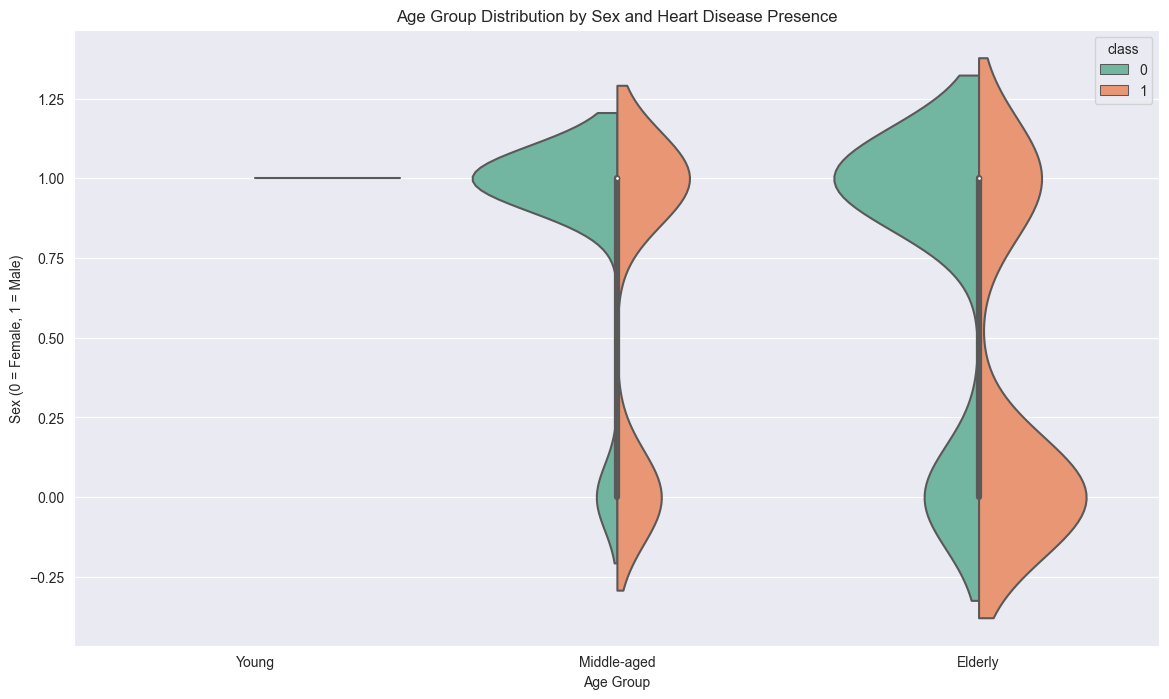

In [46]:
# Violin Plot for Age Group by Heart Disease Presence and Sex
plt.figure(figsize=(14, 8))
sns.violinplot(data=df, x='age_binned', y='sex', hue='class', split=True)
plt.title('Age Group Distribution by Sex and Heart Disease Presence')
plt.xlabel('Age Group')
plt.ylabel('Sex (0 = Female, 1 = Male)')
plt.show()


# Deriving the Structure using R and bnlearn

The 'bnlearn' package in R is used to derive the structure of our network. This process invlolved two main steps: learning the structure from the data and visualizing it for interpretability. :

1. **Learning the structure from the data**: The 'hill-climbing' algorithm is used to learn the structure of the network from the data. This algorithm is a greedy search algorithm that starts with no edges and adds or removes edges to maximize the score of the network. The score of the network is calculated using the Bayesian Information Criterion (BIC), which is a measure of the likelihood of the data given the model. The 'bnlearn' package in R is used to learn the structure of the network from the data.

2. **Visualizing the structure of the network**: The 'graphviz' package in R is used to visualize the structure of the network. The 'graphviz' package is a powerful tool for visualizing graphs and networks. The 'graphviz' package in R is used to visualize the structure of the network.

The structure of the network is learned from the data using the 'hill-climbing' algorithm and visualized using the 'graphviz' package in R. The structure of the network is then used to make predictions about the presence of heart disease based on the other variables in the network.

![Bayesian Network](plot.png)


### Step 2: Define the Structure

We define the structure of our Bayesian network by specifying the relationships between variables.

In [35]:
# use pgmpy to define the structure of the Bayesian network
model = BayesianNetwork([
    ('cp', 'exang'),                # Chest pain type influences exercise-induced angina
    ('exang', 'class'),             # Exercise-induced angina influences heart disease class
    ('restecg', 'class'),           # Resting electrocardiographic results influence heart disease class
    ('thal', 'class'),              # Thalassemia influences heart disease class
    ('sex', 'class'),               # Certain heart disease classes are more prevalent in a particular sex
    ('class', 'slope'),             # Heart disease class influences the slope of the peak exercise ST segment
    ('sex', 'age_binned'),          # Sex influences age (binned)
    ('sex', 'trestbps_binned'),     # Sex influences resting blood pressure (binned)
    ('sex', 'chol_binned'),         # Sex influences cholesterol level (binned)
    ('sex', 'thalach_binned'),      # Sex influences maximum heart rate achieved (binned)
    ('slope', 'oldpeak_binned'),    # Slope of the peak exercise ST segment influences ST depression induced by exercise relative to rest (binned)
    ('ca', 'age_binned'),           # Number of major vessels colored by fluoroscopy influences age (binned)
    ('ca', 'trestbps_binned'),      # Number of major vessels influences resting blood pressure (binned)
    ('ca', 'thalach_binned'),       # Number of major vessels influences maximum heart rate achieved (binned)
    ('ca', 'chol_binned')           # Number of major vessels influences cholesterol level (binned)
])



# Estimating the Conditional Probability Distributions

In this section of our analysis, we utilize the MaximumLikelihoodEstimator to learn the Conditional Probability Distributions (CPDs) of our Bayesian network model. This is a crucial step in the process of Bayesian modeling, as CPDs quantify the relationships between variables in the network. Here’s a breakdown of what this code does and why it's important:

## What is Maximum Likelihood Estimation (MLE)?

Maximum Likelihood Estimation (MLE) is a statistical method used to estimate the parameters of a probability distribution, based on observed data. In the context of Bayesian networks, it's used to estimate the probabilities that define the CPDs for each node (variable) in the network.

The goal of MLE is to find the set of parameters (in our case, probability values for CPDs) that makes the observed data most likely. It does this by maximizing a likelihood function, which measures how well the data fits a given model.

**The model.fit() Function:**
model.fit(df estimator=MaximumLikelihoodEstimator): This line of code applies the MLE method to our dataset df to learn the CPDs for our Bayesian network, which is stored in the variable model.

df: This is the DataFrame containing our dataset. It includes all the variables (nodes) and their observations (data points) that we'll use to learn the CPDs.

estimator=MaximumLikelihoodEstimator: This argument specifies that we're using the Maximum Likelihood Estimation technique as our method for learning the CPDs. It's a directive to the fit() function on how to estimate the probabilities.

## Why is this Important?
Learning the CPDs is fundamental to the functionality of a Bayesian network. The CPDs provide the basis for the network to make probabilistic inferences. By understanding the probability distributions of each variable conditioned on the states of other variables, the network can predict the likelihood of various outcomes, given a set of observations.

In [36]:
# Use Maximum Likelihood Estimator to learn the CPDs based on the learned structure
model.fit(df, estimator=MaximumLikelihoodEstimator)


These CPDs provide a wealth of information about the probabilistic relationships within the Bayesian network model focused on heart disease prediction. Let's dive into the explanations:

**CPD for Chest Pain (cp)**
This table shows the prior probability distribution of experiencing different types of chest pain, without conditioning on other variables:

cp(0) - Asymptomatic: 48.49% chance of not experiencing any symptoms.
cp(1) - Typical Angina: 16.29% chance of experiencing chest pain typical of heart disease.
cp(2) - Atypical Angina: 27.71% chance of experiencing chest pain not specific to heart disease.
cp(3) - Non-Anginal Pain: 7.51% chance of experiencing chest pain not related to the heart.

**CPD for Exercise-Induced Angina (exang)**
This conditional probability distribution indicates how the likelihood of experiencing exercise-induced angina varies depending on the type of chest pain:

The probability of experiencing exercise-induced angina (exang(1)) increases with certain types of chest pain, being lowest for cp(0) and highest for cp(3).

**CPD for Heart Disease Class (class)**
This complex CPD shows how the probability of having heart disease (class) is influenced by a combination of factors including exercise-induced angina (exang), resting electrocardiographic results (restecg), sex, and thalassemia (thal). For some combinations of these conditions, the risk of heart disease is equally split (50-50), while other conditions aren't detailed here.

**CPD for Resting Electrocardiographic Results (restecg)**
restecg(0) - Normal: 48.49% have normal ECG results.
restecg(1) - Having ST-T wave abnormality: 50.05% show ST-T wave abnormalities, indicating possible heart disease.
restecg(2) - Showing probable or definite left ventricular hypertrophy: 1.46% show signs of left ventricular hypertrophy.

**CPD for Thalassemia (thal)**
This table represents the probability distribution of thalassemia traits in the population:

thal(0) - Normal: A very small portion (0.68%) does not exhibit thalassemia.
thal(1) - Fixed defect: 6.24% have a fixed defect, indicating no blood flow change.
thal(2) - Normal blood flow: The majority (53.07%) show normal blood flow.
thal(3) - Reversible defect: 40% have a reversible defect, indicating abnormal blood flow is observed.

**CPD for Sex**
This simple CPD shows the distribution between male and female in the dataset:

sex(0) - Female: 30.44% of the population.
sex(1) - Male: 69.56% of the population.
CPD for Slope of the Peak Exercise ST Segment (slope)
Conditioned on the class (presence of heart disease), this table shows how the slope of the peak exercise ST segment varies:

slope(0) - Upsloping: Suggests a lower risk of heart disease.
slope(1) and slope(2): Show a relationship with the presence of heart disease, with slope(2) (Flat) being more common in those with heart disease.

**CPDs for Age, Blood Pressure, Cholesterol, Heart Rate, and ST Depression** 

These CPDs show how various health indicators are influenced by factors like the presence of major vessels colored by fluoroscopy (ca) and sex. They demonstrate the conditional relationships, such as older age being more common in certain conditions or how cholesterol levels vary with sex and the presence of heart disease.

**CPD for the Number of Major Vessels Colored by Fluoroscopy (ca)**
Indicates the distribution of patients based on the number of major vessels observed through fluoroscopy, a critical factor in diagnosing heart disease.

# Performing Predictive Inference with Bayesian Networks

After constructing our Bayesian network and learning the conditional probability distributions (CPDs), the next crucial step is to utilize the model for predictive inference. Predictive inference allows us to estimate the probaility of certain outcomes, given a set of observed evidence. In this section, we demonstrate how to perform these inferences using hypothetical patient scenarios

## Variable Elimination Technique

To conduct predictive inference, we employ the 'VariableElimination' technique on our Bayesian model:

This method efficiently computes the probability distribution of a set of query variables, conditioned on observed evidence. It systematically eliminates variables that are not part of the query or evidence, simplifying computations and enabling us to focus on the variables of interest.

Alex: Middle-aged male with typical angina, normal cholesterol, and normal resting blood pressure.

In [17]:
infer = VariableElimination(model)

evidence_alex = {
    'age_binned': 'Middle-aged',
    'sex': 1,
    'cp': 3,
    'chol_binned': 'Desirable',  # Assuming good cholesterol level
    'trestbps_binned': 'Normal',  # Assuming normal blood pressure
    'thalach_binned': 'Above Average',  # Assuming good fitness
    'oldpeak_binned': 'Minimal'  # Assuming minimal ST depression
}

# Compute the probability of heart disease class given the evidence
result = infer.query(variables=['class'], evidence=evidence_alex)
print(result)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.3826 |
+----------+--------------+
| class(1) |       0.6174 |
+----------+--------------+


The results suggest that, given the specific health information provided for Alex, our Bayesian network model predicts a higher probability of heart disease presence (61.74%) than absence (38.26%). It's important to note that these probabilities are derived from the learned relationships and patterns within the data used to train the model and the specific evidence provided about Alex.

Dana: Middle-aged female with asymptomatic chest pain, borderline high cholesterol, and normal resting blood pressure.

In [18]:
evidence_dana = {
    'age_binned': 'Middle-aged',
    'sex': 0,
    'cp': 0,
    'chol_binned': 'Borderline high',
    'trestbps_binned': 'Normal',
    'thalach_binned': 'Average',
    'oldpeak_binned': 'Moderate'
}

# Compute the probability of heart disease class given the evidence
result = infer.query(variables=['class'], evidence=evidence_dana)
print(result)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.6010 |
+----------+--------------+
| class(1) |       0.3990 |
+----------+--------------+


This result suggests that Dana has a 60.10% chance of not having heart disease and a 39.90% chance of having heart disease. Compared to Alex, Dana's health profile indicates a lower risk of heart disease according to the model.

Eli: Elderly male with non-anginal pain, high cholesterol, but low resting blood pressure.

In [19]:
evidence_eli = evidence_eli = {
    'age_binned': 'Elderly',
    'sex': 1,
    'cp': 2,
    'chol_binned': 'High',
    'trestbps_binned': 'Low',
    'thalach_binned': 'Average',
    'oldpeak_binned': 'Severe'
}

# Compute the probability of heart disease class given the evidence
result = infer.query(variables=['class'], evidence=evidence_eli)

print(result)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5972 |
+----------+--------------+
| class(1) |       0.4028 |
+----------+--------------+


These probabilities suggest that, according to the Bayesian network model and the evidence provided for Eli, there's a 59.72% chance that Eli does not have heart disease and a 40.28% chance that he does. Despite some high-risk factors like high cholesterol and severe ST depression, the model assesses Eli's overall risk of having heart disease as lower than the risk of not having it.

Casey: Young male with atypical angina, desirable cholesterol levels, and low resting blood pressure.

In [20]:
evidence_casey = {
    'age_binned': 'Young',
    'sex': 1,
    'cp': 1,
    'chol_binned': 'Desirable',
    'trestbps_binned': 'Low',
    'thalach_binned': 'Above Average',
    'oldpeak_binned': 'Minimal'
}

# Compute the probability of heart disease class given the evidence
result = infer.query(variables=['class'], evidence=evidence_casey)
print(result)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.3653 |
+----------+--------------+
| class(1) |       0.6347 |
+----------+--------------+


Casey's health profile—being young, male, with a certain type of chest pain, desirable cholesterol levels, low resting blood pressure, above-average maximum heart rate achieved, and minimal ST depression—leads the model to estimate a 63.47% chance of having heart disease and a 36.53% chance of not having it. This high probability might seem counterintuitive given the positive health indicators, suggesting that the model might be picking up on nuanced patterns or that Casey's profile matches patterns of individuals with heart disease within the data the model was trained on.

Blake: Elderly female with non-anginal pain, high cholesterol, and high resting blood pressure.

In [21]:
evidence_blake = {
    'age_binned': 'Elderly',
    'sex': 0,
    'cp': 2,
    'chol_binned': 'High',
    'trestbps_binned': 'High',
    'thalach_binned': 'Below Average',
    'oldpeak_binned': 'Severe'
}

# Compute the probability of heart disease class given the evidence
result = infer.query(variables=['class'], evidence=evidence_blake)
print(result)


+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5432 |
+----------+--------------+
| class(1) |       0.4568 |
+----------+--------------+


Blake's results show a more balanced probability distribution between having and not having heart disease, indicating that her risk factors contribute to a moderate likelihood of heart disease according to the model.

In [23]:
from pgmpy.sampling import BayesianModelSampling

# Create a sampler object
sampler = BayesianModelSampling(model)

# Generate a random sample of 10,000 records
samples = sampler.forward_sample(size=10000)

# Filter samples where exercise-induced angina ('exang') is present 
samples_with_exang = samples[samples['exang'] == 1]

# Now, print the probability distribution of chest pain type ('cp') given the filtered samples
cp_distribution_given_exang = samples_with_exang['cp'].value_counts(normalize=True)
cp_distribution_given_exang


  0%|          | 0/13 [00:00<?, ?it/s]

/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/pgmpy/sampling/base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


cp
0    0.816789
2    0.111046
3    0.039764
1    0.032401
Name: proportion, dtype: float64

This distribution offers valuable insights into the correlation between exercise-induced angina and the types of chest pain these patients experience. Notably, a significant majority of patients with exercise-induced angina experience Type 0 chest pain, which is classified as asymptomatic. This suggests that among this specific group, the chest pain most commonly does not align with the traditional symptoms of angina that are easily recognizable.

Types 2 and 3 chest pain, which represent non-anginal and atypical angina pain, respectively, account for a smaller portion of the distribution, indicating that these types of chest pain are less common among patients with exercise-induced angina. Type 1, typical angina, is the least common, which may initially seem counterintuitive but underscores the complexity of diagnosing heart conditions based solely on symptom presentation.

# Probabilistic Inference Using Belief Propagation (BP):

In this part of our analysis, we employ the Belief Propagation (BP) algorithm to conduct probabilistic inference on our Bayesian network. This method allows us to calculate the posterior probabilities of certain events, given observed evidence, by propagating beliefs (probabilities) through the network in an efficient manner.

In [24]:
from pgmpy.inference import BeliefPropagation
bp = BeliefPropagation(model)
bp.calibrate()

# Query 1:alex 
q1 = bp.query(variables=['class'], evidence=evidence_alex)
print(q1)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.3826 |
+----------+--------------+
| class(1) |       0.6174 |
+----------+--------------+


In [25]:
# Query 2: Dana
q2 = bp.query(variables=['class'], evidence=evidence_dana)
print(q2)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.6010 |
+----------+--------------+
| class(1) |       0.3990 |
+----------+--------------+


In [30]:

# Query 3: Eli
q3 = bp.query(variables=['class'], evidence=evidence_eli)

# Print the result
print(q3)


+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5972 |
+----------+--------------+
| class(1) |       0.4028 |
+----------+--------------+


In [31]:
# Query 4: Casey
q4 = bp.query(variables=['class'], evidence=evidence_casey)

# Print the result
print(q4)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.3653 |
+----------+--------------+
| class(1) |       0.6347 |
+----------+--------------+


In [32]:
# Query 5: Blake
q5 = bp.query(variables=['class'], evidence=evidence_blake)

# Print the result
print(q5)


+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       0.5432 |
+----------+--------------+
| class(1) |       0.4568 |
+----------+--------------+


# Try Your Own Heart Disease Risk Predictions

We've developed a predictive model that assesses the risk of heart disease based on various health indicators. To make this model accessible and interactive, we've created a user-friendly interface using Gradio. This tool allows you to input hypothetical patient scenarios and receive instant predictions on the likelihood of heart disease.

### How to Use the Interface:
* Input Data: Use the sliders and dropdown menus to enter health characteristics for a hypothetical patient. These characteristics include chest pain type, the presence of exercise-induced angina, resting electrocardiographic results, sex, thalassemia status, the slope of the peak exercise ST segment, and more.

* View Predictions: After entering the data, the model will compute the probability distribution of heart disease presence (class 0 for absence and class 1 for presence) based on the input evidence.

* Explore Different Scenarios: Feel free to adjust the inputs to explore how different health profiles affect the predicted risk of heart disease. This interactive exploration can provide insights into the factors that the model considers significant in assessing heart disease risk.


In [28]:
import gradio as gr
from pgmpy.inference import VariableElimination

# Define the prediction function with arguments for all variables
def predict_class_probability(cp, exang, restecg, sex, thal, slope, age_binned, trestbps_binned, chol_binned, thalach_binned, oldpeak_binned, ca):
    evidence = {
        'cp': cp,
        'exang': exang,
        'restecg': restecg,
        'sex': sex,
        'thal': thal,
        'slope': slope,
        'age_binned': age_binned,
        'trestbps_binned': trestbps_binned,
        'chol_binned': chol_binned,
        'thalach_binned': thalach_binned,
        'oldpeak_binned': oldpeak_binned,
        'ca': ca
    }
    
    # Create an inference object
    infer = VariableElimination(model)
    
    # Query the probability distribution of heart disease class given the evidence
    prob_class = infer.query(variables=['class'], evidence=evidence).values.flatten()
    
    # Normalize probabilities
    prob_class_normalized = prob_class / prob_class.sum()

    assert prob_class_normalized.sum() == 1, 'Probabilities do not sum to 1'
    

    class_probabilities = {f'Class {idx}': prob for idx, prob in enumerate(prob_class_normalized)}
    
    return class_probabilities

# Create the Gradio interface with sliders for numerical variables and dropdowns for categorical variables
interface = gr.Interface(fn=predict_class_probability, 
                         inputs=[gr.inputs.Slider(minimum=0, maximum=3, step=1, label='Chest Pain Type (cp)'),
                                 gr.inputs.Slider(minimum=0, maximum=1, step=1, label='Exercise-induced Angina (exang)'),
                                 gr.inputs.Slider(minimum=0, maximum=2, step=1, label='Resting Electrocardiographic Results (restecg)'),
                                 gr.inputs.Slider(minimum=0, maximum=1, step=1, label='Sex (sex)'),
                                 gr.inputs.Slider(minimum=0, maximum=3, step=1, label='Thalassemia (thal)'),
                                 gr.inputs.Slider(minimum=0, maximum=2, step=1, label='Slope of Peak Exercise ST Segment (slope)'),
                                 gr.inputs.Radio(['Young', 'Middle-aged', 'Elderly'], label='Age Group (age_binned)'),
                                 gr.inputs.Radio(['Low', 'Normal', 'High'], label='Resting Blood Pressure Group (trestbps_binned)'),
                                 gr.inputs.Radio(['Desirable', 'Borderline high', 'High'], label='Cholesterol Group (chol_binned)'),
                                 gr.inputs.Radio(['Below Average', 'Average', 'Above Average'], label='Maximum Heart Rate Achieved Group (thalach_binned)'),
                                 gr.inputs.Radio(['Minimal', 'Moderate', 'Severe'], label='ST Depression Group (oldpeak_binned)'),
                                 gr.inputs.Slider(minimum=0, maximum=3, step=1, label='Number of Major Vessels Colored by Fluoroscopy (ca)')],
                         outputs=gr.outputs.Label(num_top_classes=2))

# Launch the interface
interface.launch(share=True)


/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/gradio/inputs.py:89: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/gradio/inputs.py:183: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/Users/jvcarmichael94/Library/Python/3.9/lib/python/site-packages/

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://2856cffc9571b53782.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
